<a href="https://colab.research.google.com/github/Pragati15-Rathi/Estimating-Motor-Temperature-using-ML/blob/main/Copy_of_LTSM%2BCNN_iynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/measures_v2.csv')

# Display column names to identify target variables
print(data.columns)

# Define target columns correctly
target_columns = ['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']

# Split the data into features and target
X = data.drop(columns=target_columns)
y = data[target_columns]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN + LSTM model
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, TimeDistributed

# Define the CNN + LSTM hybrid model with fewer layers and units
def cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = tf.expand_dims(x, axis=1)  # Add time dimension for LSTM

    # LSTM layers
    x = LSTM(50, activation='relu', return_sequences=True)(x)
    x = LSTM(50, activation='relu')(x)

    # Output layer
    outputs = Dense(len(target_columns))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Ensure that the Google Colab runtime is set to CPU
input_shape = (X_train_scaled.shape[1], 1)
model = cnn_lstm_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

# Train the model with fewer epochs and larger batch size
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=10, batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 1)]            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 32)             128       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 3, 32)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 96)                0         
                                                                 
 tf.expand_dims_3 (TFOpLamb  (None, 1, 96)             0         
 da)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 50)             2940

33271/33271 [==============================] - 92s 3ms/step
CNN + LSTM Train R² Score: 0.9173732714049906
CNN + LSTM Train MSE: 45.87003380474893
8318/8318 [==============================] - 22s 3ms/step
CNN + LSTM Test R² Score: 0.9165935957816662
CNN + LSTM Test MSE: 46.303784279809925


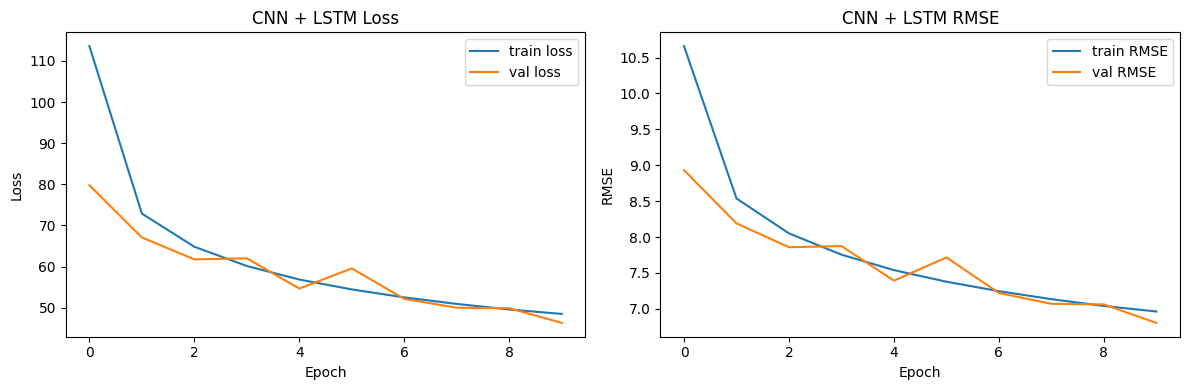

In [ ]:
# Predict and evaluate on training set
y_train_pred = model.predict(X_train_reshaped)
r2_cnn_lstm_train = r2_score(y_train, y_train_pred)
mse_cnn_lstm_train = mean_squared_error(y_train, y_train_pred)
print(f"CNN + LSTM Train R² Score: {r2_cnn_lstm_train}")
print(f"CNN + LSTM Train MSE: {mse_cnn_lstm_train}")

# Predict and evaluate on test set
y_test_pred = model.predict(X_test_reshaped)
r2_cnn_lstm_test = r2_score(y_test, y_test_pred)
mse_cnn_lstm_test = mean_squared_error(y_test, y_test_pred)
print(f"CNN + LSTM Test R² Score: {r2_cnn_lstm_test}")
print(f"CNN + LSTM Test MSE: {mse_cnn_lstm_test}")

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('CNN + LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='val RMSE')
plt.title('CNN + LSTM RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


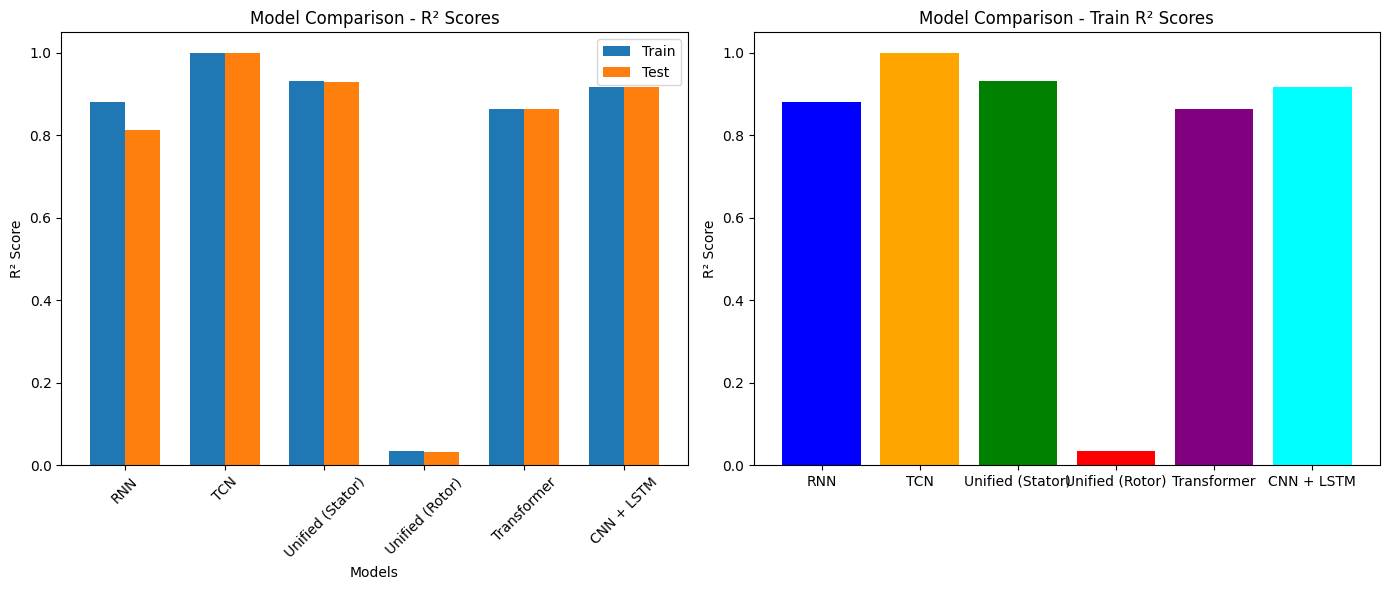

CNN + LSTM R² Score - Train: 0.9173732714049906, Test: 0.9165935957816662
Transformer R² Score - Train: 0.8635, Test: 0.8634
R² score for RNN model - Train: 0.8803, Test: 0.8141
R² score for TCN model - Train: 0.9998, Test: 0.9999
R² score for Unified model (Stator) - Train: 0.9323, Test: 0.9291
R² score for Unified model (Rotor) - Train: 0.0349, Test: 0.0329


In [ ]:
# Update the model performance metrics
models = ['RNN', 'TCN', 'Unified (Stator)', 'Unified (Rotor)', 'Transformer', 'CNN + LSTM']
train_r2_scores = [0.8803, 0.9998, 0.9323, 0.0349, 0.8635, r2_cnn_lstm_train]
test_r2_scores = [0.8141, 0.9999, 0.9291, 0.0329, 0.8634, r2_cnn_lstm_test]

# Plot the R² scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_r2_scores, bar_width, label='Train')
plt.bar(index + bar_width, test_r2_scores, bar_width, label='Test')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Comparison - R² Scores')
plt.xticks(index + bar_width / 2, models, rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(models, train_r2_scores, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'])
plt.ylabel('R² Score')
plt.title('Model Comparison - Train R² Scores')

plt.tight_layout()
plt.show()

# Print the performance
print(f"CNN + LSTM R² Score - Train: {r2_cnn_lstm_train}, Test: {r2_cnn_lstm_test}")
print(f"Transformer R² Score - Train: {0.8635}, Test: {0.8634}")
print(f"R² score for RNN model - Train: {0.8803}, Test: {0.8141}")
print(f"R² score for TCN model - Train: {0.9998}, Test: {0.9999}")
print(f"R² score for Unified model (Stator) - Train: {0.9323}, Test: {0.9291}")
print(f"R² score for Unified model (Rotor) - Train: {0.0349}, Test: {0.0329}")
